
# Visualize every Player Gaze

In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import fu
from FRVRS import nu
import os
import os.path as osp
import re

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape) # (842663, 112)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(829277, 114)



#### Visualize the patients-gazed-at in on one scene's timeline

In [4]:

# nu.get_regexed_columns(frvrs_logs_df, search_regex=re.compile('gaze', re.IGNORECASE))

In [5]:

# nu.get_regexed_dataframe(frvrs_logs_df, ['action_type'], search_regex=re.compile('gaze', re.IGNORECASE)).dropna(axis='columns', how='all').T

In [6]:

# Get the scene with the largest number of patients gazed at
mask_series = (frvrs_logs_df.action_type.isin(['PLAYER_GAZE']))
mask_series &= ~frvrs_logs_df.player_gaze_patient_id.isnull()
multiindex_dict = {}
multiindex = frvrs_logs_df[mask_series].groupby(['session_uuid', 'scene_id']).player_gaze_patient_id.nunique().sort_values().tail(1).index
for name in multiindex.names: multiindex_dict[name] = multiindex.get_level_values(name)[0]
multiindex_dict

{'session_uuid': 'd9d58da9-9bdc-41ea-90fe-4c84db4635d9', 'scene_id': 0}

In [7]:

# Get the SALT colors for each patient in the scene
scene_mask_series = (frvrs_logs_df.session_uuid == multiindex_dict['session_uuid']) & (frvrs_logs_df.scene_id == multiindex_dict['scene_id'])
scene_df = frvrs_logs_df[scene_mask_series]
patient_color_dict = {}
mask_series = ~scene_df.patient_record_salt.isnull()
for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
    patient_color_dict[patient_id] = fu.salt_to_tag_dict[fu.get_max_salt(patient_df=patient_df)]
patient_color_dict

{'Bob_1 Root': 'gray', 'Bob_10 Root': 'red', 'Bob_12 Root': 'red', 'Bob_7 Root': 'yellow', 'Gary_16 Root': 'green', 'Gary_2 Root': 'red', 'Helga_14 Root': 'red', 'Helga_17 Root': 'gray', 'Helga_6 Root': 'yellow', 'Helga_9 Root': 'green', 'Lily_0 Root': 'black', 'Lily_11 Root': 'red', 'Lily_15 Root': 'red', 'Lily_5 Root': 'red', 'Mike_13 Root': 'yellow', 'Mike_3 Root': 'red', 'Mike_4 Root': 'red', 'Mike_8 Root': 'green'}

In [8]:

# Get the SORT colors for each patient in the scene
%matplotlib inline

scene_mask_series = (frvrs_logs_df.session_uuid == multiindex_dict['session_uuid']) & (frvrs_logs_df.scene_id == multiindex_dict['scene_id'])
scene_df = frvrs_logs_df[scene_mask_series]
print([cn for cn in scene_df.columns if cn.endswith('_sort')])
patient_color_dict = {}
mask_series = ~scene_df.patient_sort.isnull()
sort_to_color_dict = {'still': 'black', 'waver': 'red', 'walker': 'green'}
for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
    patient_color_dict[patient_id] = sort_to_color_dict.get(patient_df.patient_sort.max(), 'grey')
patient_color_dict

['patient_demoted_sort', 'patient_record_sort', 'patient_engaged_sort', 'patient_sort']


{'Bob_1 Root': 'black', 'Bob_10 Root': 'red', 'Bob_12 Root': 'red', 'Bob_7 Root': 'red', 'Gary_16 Root': 'green', 'Gary_2 Root': 'red', 'Helga_14 Root': 'red', 'Helga_17 Root': 'black', 'Helga_6 Root': 'red', 'Helga_9 Root': 'green', 'Lily_0 Root': 'black', 'Lily_11 Root': 'green', 'Lily_15 Root': 'red', 'Lily_5 Root': 'red', 'Mike_13 Root': 'red', 'Mike_3 Root': 'black', 'Mike_4 Root': 'red', 'Mike_8 Root': 'green'}

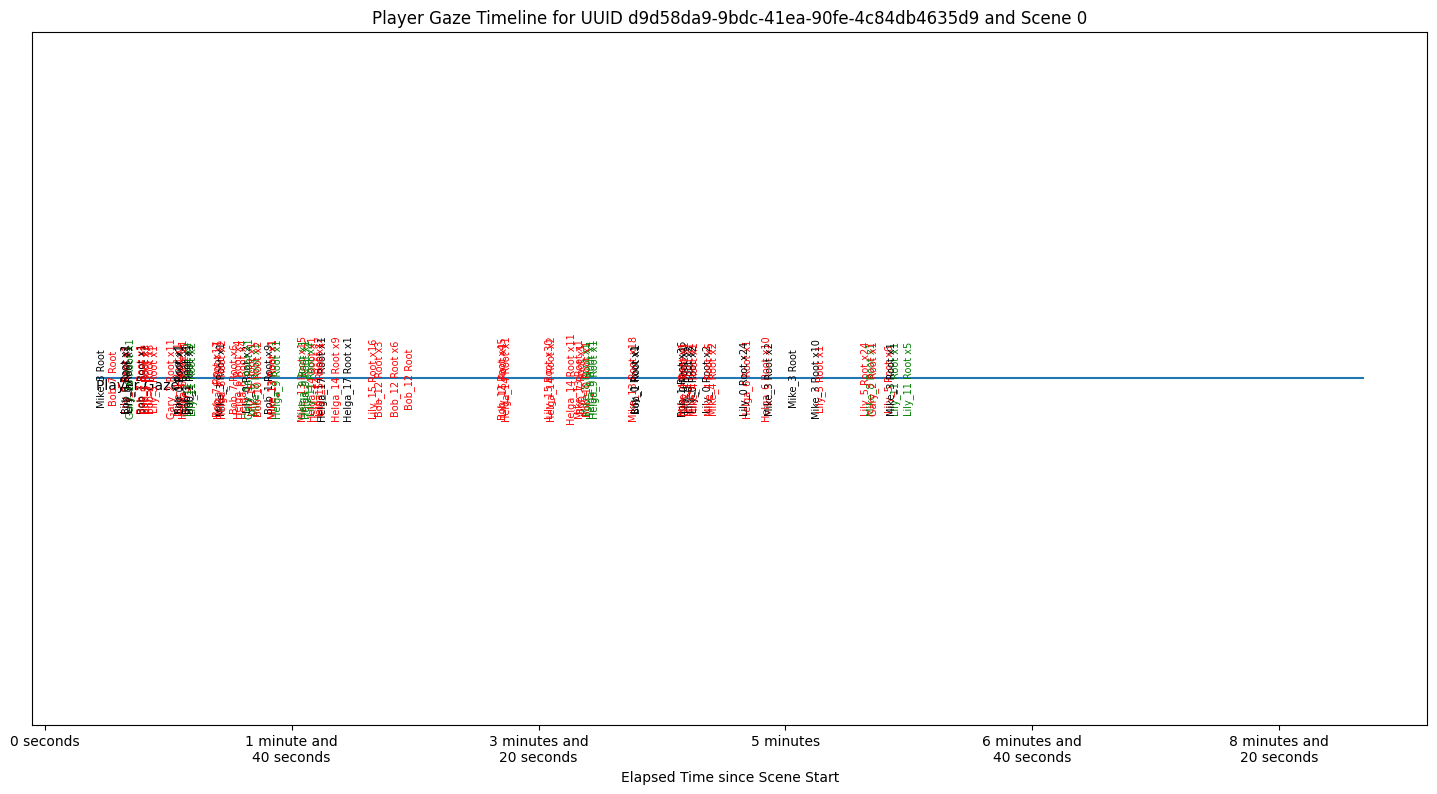

In [9]:

random_session_uuid, random_time_group = fu.show_gaze_timeline(
    frvrs_logs_df=frvrs_logs_df, random_session_uuid=multiindex_dict['session_uuid'], random_time_group=multiindex_dict['scene_id'], consecutive_cutoff=5_000,
    patient_color_dict=patient_color_dict, verbose=False
)

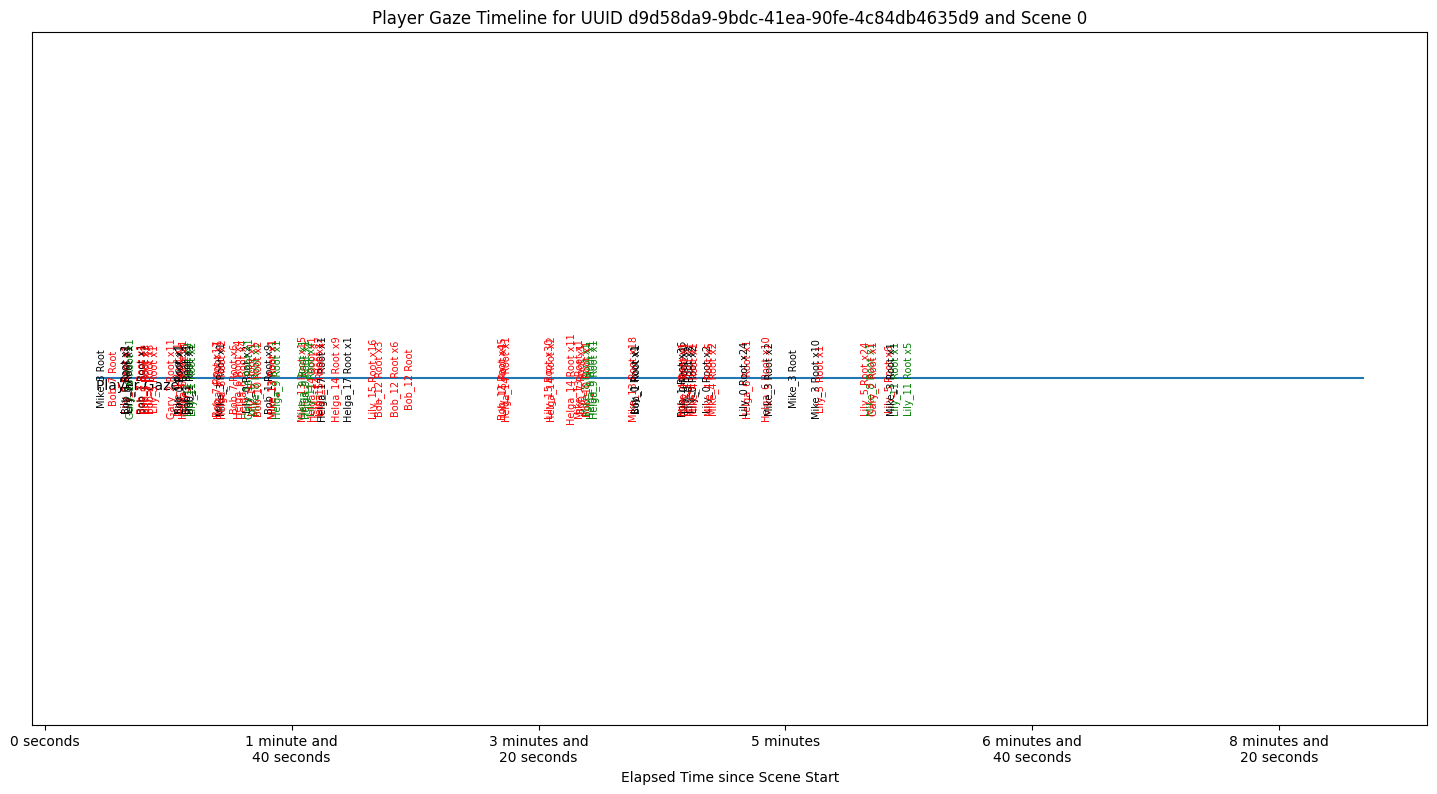

In [10]:

# Get the SORT colors for each patient in the scene
scene_mask_series = (frvrs_logs_df.session_uuid == random_session_uuid) & (frvrs_logs_df.scene_id == random_time_group)
scene_df = frvrs_logs_df[scene_mask_series]
patient_color_dict = {}
mask_series = ~scene_df.patient_sort.isnull()
sort_to_color_dict = {'still': 'black', 'waver': 'red', 'walker': 'green'}
for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
    patient_color_dict[patient_id] = sort_to_color_dict[patient_df.patient_sort.max()]
random_session_uuid, random_time_group = fu.show_gaze_timeline(
    frvrs_logs_df=frvrs_logs_df, random_session_uuid=random_session_uuid, random_time_group=random_time_group, consecutive_cutoff=5_000,
    patient_color_dict=patient_color_dict, verbose=False
)

In [11]:

# Visualize each patient being gazed at by the player
columns_list = ['patient_id', 'action_type']

# Loop through each unique file and scene combination
time_groups_dict = {}
consecutive_time_groups_dict = {}
for (session_uuid, scene_id), scene_df in fu.get_session_groupby(extra_column='scene_id'):
    mask_series = (scene_df.action_type.isin(['PLAYER_GAZE', 'SESSION_END', 'SESSION_START']))
    key = (session_uuid, scene_id)
    actions_list = []
    patient_ids_set = set()
    for row_index, row_series in scene_df[mask_series].sort_values('action_tick')[columns_list].iterrows():
        patient_id = row_series.patient_id
        action_type = row_series.action_type
        if (action_type == 'PLAYER_GAZE'):
            actions_list.append(patient_id)
            patient_ids_set.add(patient_id)
        else: actions_list.append(action_type)
    time_groups_dict[key] = actions_list
    for patient_id in patient_ids_set: actions_list = fu.replace_consecutive_elements(actions_list, element=patient_id)
    consecutive_time_groups_dict[key] = actions_list

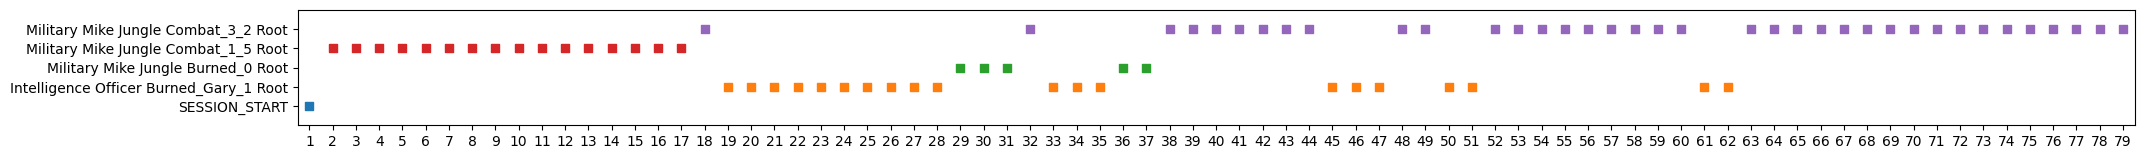

In [12]:

# Plot the time groups sequence with the shortest length
scene_tuple, sequence = sorted([(k, v) for k, v in time_groups_dict.items()], key=lambda x: len(x[1]), reverse=True)[6]
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1])
scene_df = frvrs_logs_df[mask_series]
patient_color_dict = {'SESSION_START': 'green', 'SESSION_END': 'red'}
mask_series = ~scene_df.patient_sort.isnull()
sort_to_color_dict = {'still': 'black', 'waver': 'red', 'walker': 'green'}
for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
    patient_color_dict[patient_id] = sort_to_color_dict.get(patient_df.patient_sort.max(), 'grey')
if(sequence): fig, ax = nu.plot_sequence(sequence, color_dict=None);

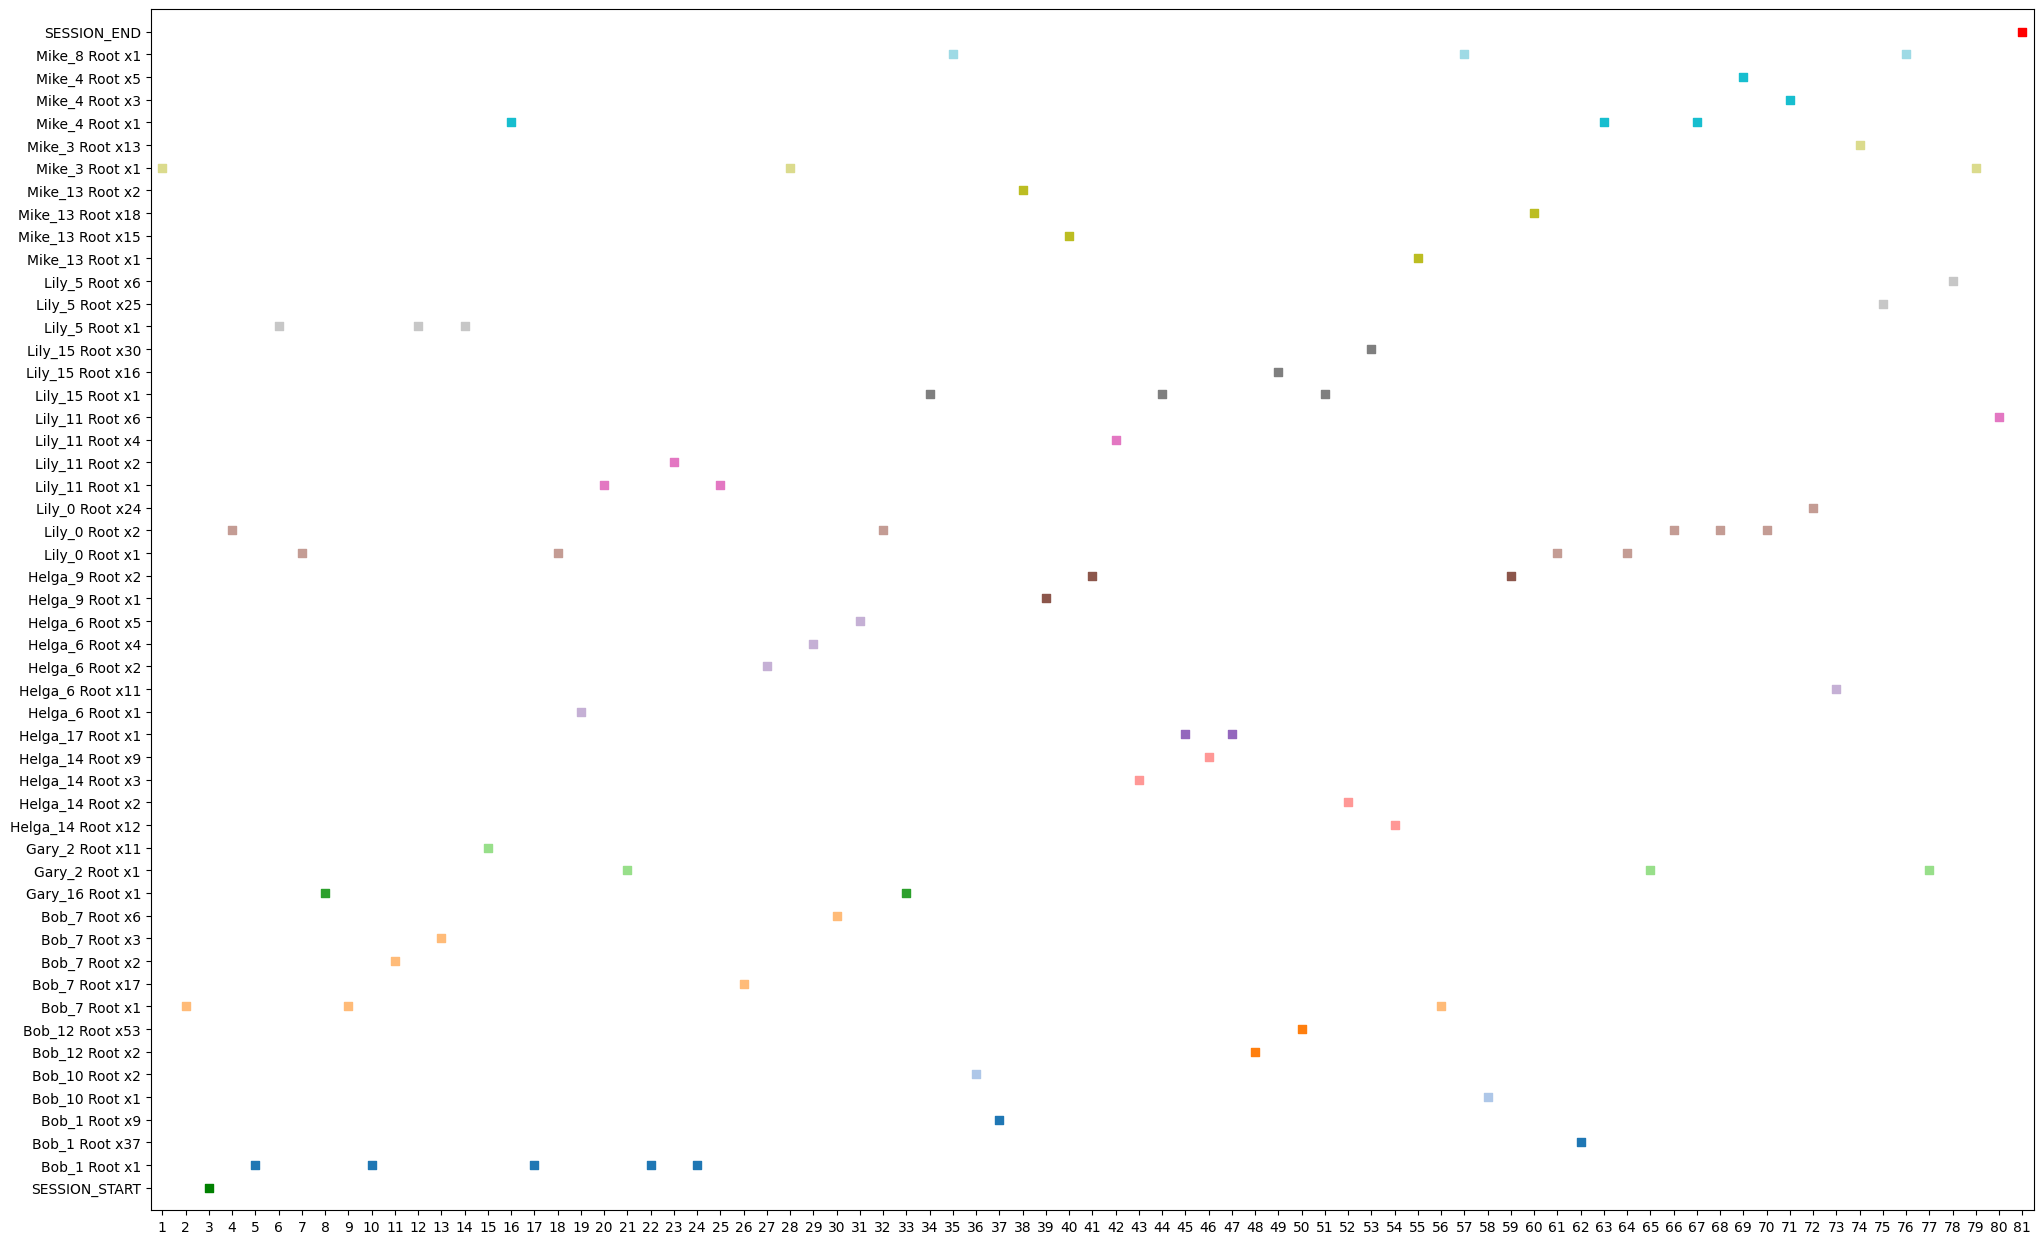

In [13]:

# Plot the consecutive time groups sequence with the shortest length
import matplotlib.colors as mcolors

scene_tuple, sequence = sorted([(k, v) for k, v in consecutive_time_groups_dict.items()], key=lambda x: len(x[1]), reverse=True)[0]
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1])
scene_df = frvrs_logs_df[mask_series]

# Get a color for each patient
patient_color_dict = {'SESSION_START': 'green', 'SESSION_END': 'red'}
color_cycler = nu.get_color_cycler(fu.get_patient_count(scene_df))
for patient_id, face_color_dict in zip(scene_df.groupby('patient_id').groups.keys(), color_cycler()):
    rgba = face_color_dict['color']
    hex_color = mcolors.to_hex(rgba)
    patient_color_dict[patient_id] = hex_color

if(sequence):    
    consec_regex = re.compile(r' x\d+$')
    for xel in sequence:
        if xel not in patient_color_dict.keys():
            el = consec_regex.sub('', xel)
            if el in patient_color_dict: patient_color_dict[xel] = patient_color_dict[el]

fig, ax = nu.plot_sequence(sequence, color_dict=patient_color_dict);

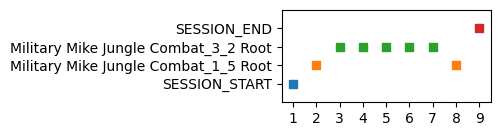

In [34]:

# Plot the time groups sequence with the shortest length
scene_tuple, sequence = sorted([(k, v) for k, v in time_groups_dict.items()], key=lambda x: len(x[1]), reverse=True)[14]
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1])
scene_df = frvrs_logs_df[mask_series]
patient_color_dict = {'SESSION_START': 'green', 'SESSION_END': 'red'}
mask_series = ~scene_df.patient_sort.isnull()
sort_to_color_dict = {'still': 'black', 'waver': 'red', 'walker': 'green'}
for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
    patient_color_dict[patient_id] = sort_to_color_dict.get(patient_df.patient_sort.max(), 'grey')
if(sequence): fig, ax = nu.plot_sequence(sequence, color_dict=None);